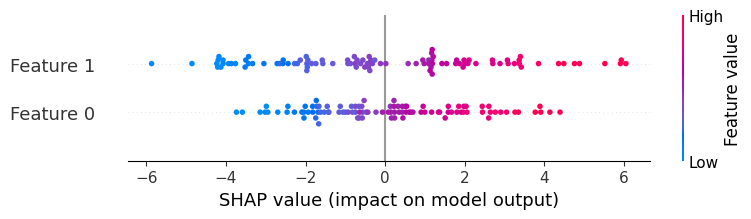

In [5]:
import shap
import xgboost as xgb
import numpy as np

# Make toy data
X = np.random.randn(100, 2)
y = 5 + 2*X[:,0] + 3*X[:,1] + np.random.randn(100)*0.1

model = xgb.XGBRegressor().fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualizations
shap.summary_plot(shap_values.values, X)
shap.force_plot(explainer.expected_value, shap_values.values[0], X[0])


In [4]:
# !pip install shap
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 840.2 kB/s eta 0:01:26
   ---------------------------------------- 0.8/72.0 MB 884.1 kB/s eta 0:01:21
    --------------------------------------- 1.0/72.0 MB 915.5 kB/s eta 0:01:18
    --------------------------------------- 1.3/72.0 MB 959.4 kB/s eta 0:01:14
    --------------------------------------- 1.6/72.0 MB 987.0 kB/s eta 0:01:12
   - -------------------------------------- 1.8/72.0 MB 1.0 MB/s eta 0:01:08
   - -------------------------------------- 2.1/72.0 MB 1.1 MB/s eta 0:01:05
   - -------------------------------------- 2.4/72.0 MB 1.1 MB/s eta 0:01:03
   - -------------------

Train accuracy: 1.0
Test accuracy : 0.9649122807017544


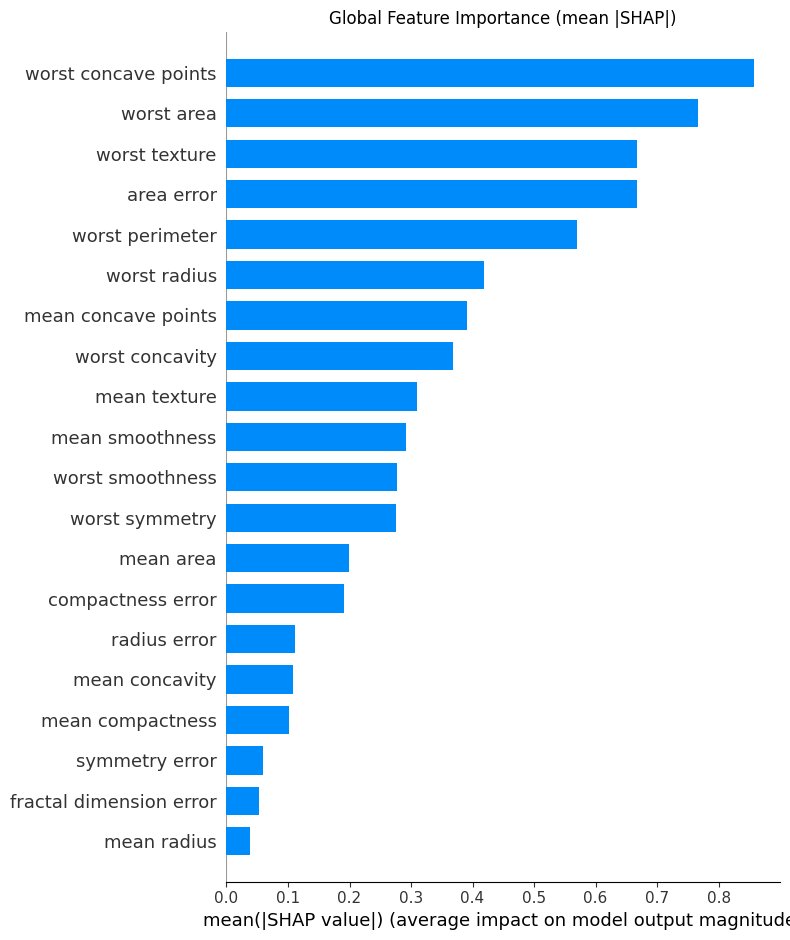

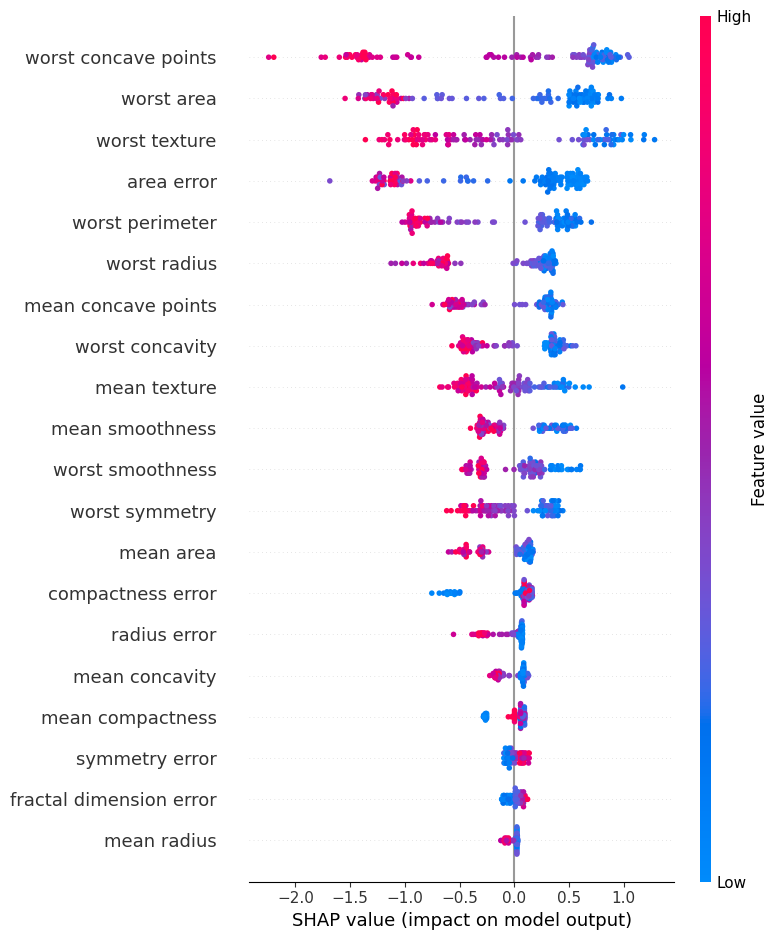

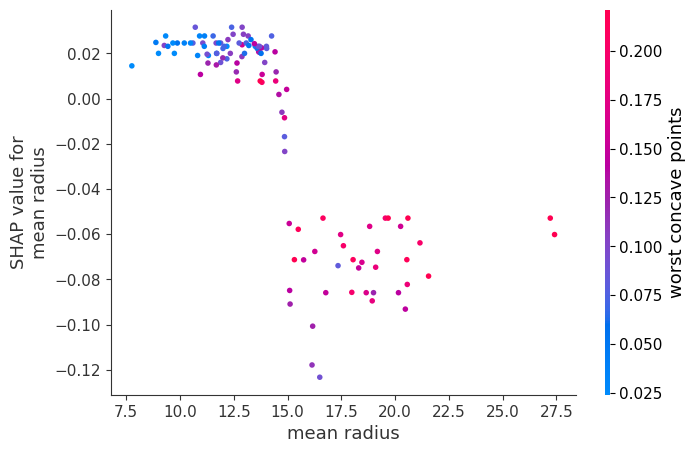

Base value (expected output): 2.113737088661358
Model output for this patient: 0.0014576161


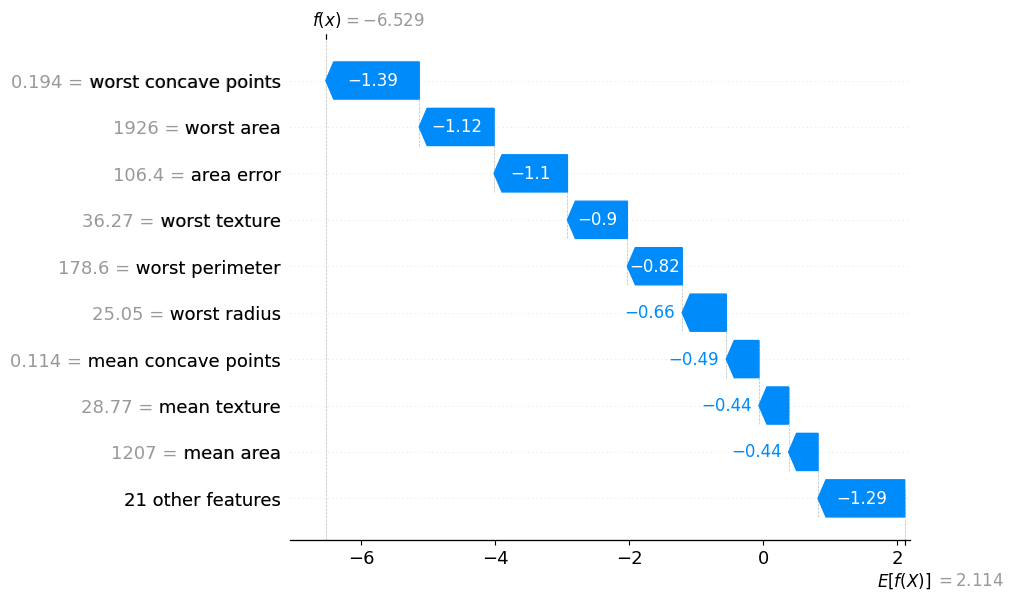

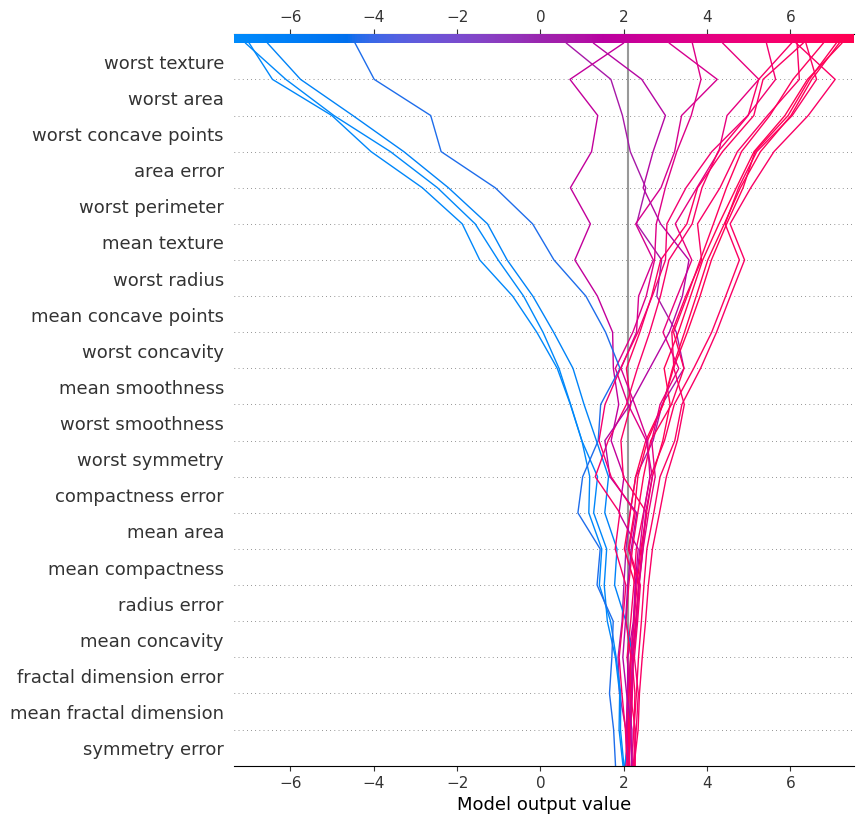

In [1]:
# ================================
# 0. Imports and setup
# ================================
import numpy as np
import matplotlib.pyplot as plt

import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# For nicer plots in Jupyter
plt.rcParams["figure.figsize"] = (8, 5)
shap.initjs()  # enables interactive JS plots (force, decision) in notebooks

# ================================
# 1. Load data and train model
# ================================
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy :", model.score(X_test, y_test))

# ================================
# 2. Create SHAP explainer and values
# ================================
# For tree-based models, Explainer will internally use TreeExplainer
explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)  # SHAP values for test set

# shap_values is a shap._explanation.Explanation object:
#   shap_values.values: array [n_samples, n_features]
#   shap_values.base_values: expected value (baseline)
#   shap_values.data: input data


# ============================================================
# 3. Global feature importance – SHAP bar plot
# ============================================================
plt.title("Global Feature Importance (mean |SHAP|)")
shap.summary_plot(
    shap_values.values,
    features=X_test,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# Explanation:
#   - Each bar: a feature
#   - Length: average absolute SHAP value across all samples
#   - Interpretation: how much this feature contributes ON AVERAGE.


# ============================================================
# 4. Global explanation – SHAP summary (beeswarm) plot
# ============================================================
shap.summary_plot(
    shap_values.values,
    features=X_test,
    feature_names=feature_names,
    show=True
)

# Explanation:
#   - Each point: one patient/sample.
#   - x-axis: SHAP value (impact on model output).
#   - Color: feature value (e.g., low=blue, high=red).
#   - Read as: "High values of this feature push prediction up/down."


# ============================================================
# 5. SHAP dependence plot (feature effect + interaction)
# ============================================================
# Choose a feature of interest, e.g. 'mean radius'
feature_to_plot = "mean radius"

shap.dependence_plot(
    feature_to_plot,
    shap_values.values,
    X_test,
    feature_names=feature_names,
    interaction_index="auto"  # or a specific feature name / index
)

# Explanation:
#   - x-axis: actual value of 'mean radius'
#   - y-axis: SHAP value for 'mean radius'
#   - Color: value of interacting feature (e.g., some other feature automatically chosen).
#   - Shows how the effect of 'mean radius' on prediction changes with its value,
#     and how another feature modifies this effect.


# ============================================================
# 6. Local explanation – Force plot for one sample
# ============================================================
# Let's pick an interesting test point
idx = 0  # you can change this index to inspect different patients

single_shap = shap_values[idx]
single_x = single_shap.data
single_base = single_shap.base_values
single_values = single_shap.values

print("Base value (expected output):", single_base)
print("Model output for this patient:", model.predict_proba(X_test[idx:idx+1])[0,1])

# Force plot in notebook (interactive)
shap.force_plot(single_base, single_values, single_x, feature_names=feature_names)

# Explanation:
#   - Red arrows: features pushing prediction HIGHER (towards malignant).
#   - Blue arrows: features pushing prediction LOWER (towards benign).
#   - Length of arrow = strength of contribution.


# ============================================================
# 7. Local explanation – Waterfall plot for one sample
# ============================================================
shap.plots.waterfall(single_shap, max_display=10)

# Explanation:
#   - Starts at the base value (average model prediction).
#   - Each bar = feature contribution added/subtracted.
#   - Final value = model's prediction for that sample.
#   - Good to show in slides for clinicians / non-ML experts.


# ============================================================
# 8. Decision plot – how features accumulate to the prediction
# ============================================================
# Decision plot for a small subset of patients
subset_idx = np.random.choice(len(X_test), size=20, replace=False)
subset_shap = shap_values[subset_idx]

shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=subset_shap.values,
    features=X_test[subset_idx],
    feature_names=feature_names
)

# Explanation:
#   - Each line = one patient.
#   - Start at base value, move left→right as features contribute.
#   - Useful to see how different patients get pushed toward
#     benign vs malignant by the same features.


The SHAP decision plot visualizes how each feature contributes to each patient’s prediction.
Red lines show samples pushed toward malignancy, blue toward benign.
Features at the top have the strongest impact, and the diverging paths explain how different patient values lead to different model outcomes.